## Import modules

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
seed = 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataloader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=50,
                                         shuffle=True,
                                         num_workers=2)

In [4]:
# Check batch size and shape of image
for i, (inputs, labels) in enumerate(trainloader, 0):
    print(inputs.size())
    print(labels.size())
    break

torch.Size([50, 1, 28, 28])
torch.Size([50])


## Create simple NN model with fully connected layers

In [5]:
class DigitClassifier1(nn.Module):
    def __init__(self):
        super(DigitClassifier1, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(x, 1)
        return x
        
clf_nn = DigitClassifier1()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(clf_nn.parameters(), lr=0.04, momentum=0.9)

In [7]:
losses = []
for inputs, labels in trainloader:
    optimizer.zero_grad()
    inputs = inputs.view(-1, 28 * 28)
    outputs = clf_nn(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print("Finished Learning")

Finished Learning


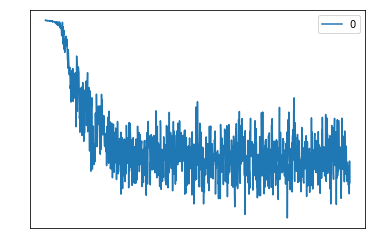

In [8]:
pd.DataFrame(losses).plot()
plt.tick_params(colors='white')

In [9]:
num_TP = 0.
num_total = 0
cm = np.zeros((10, 10))
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28 * 28)
        outputs = clf_nn(inputs)
        _, pred = torch.max(outputs.data, 1)
        cm += np.array(confusion_matrix(pred, labels, labels=np.arange(10)))
        num_total += labels.size(0)
        num_TP += (pred == labels).sum().item()
print(f'Accuracy: {num_TP / num_total * 100}%')

Accuracy: 64.61%


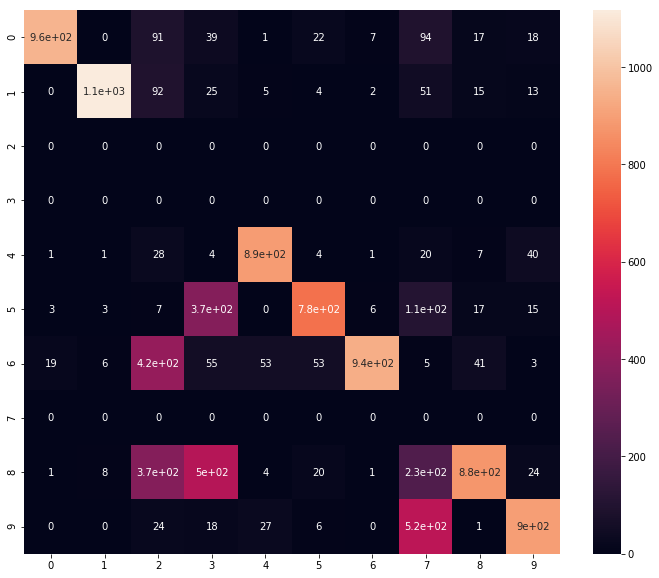

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, ax=ax)
sns.set_style("darkgrid")

8 is mainly misclassified as 5.

## Create NN model with CNN layers

In [11]:
class DigitClassifier2(nn.Module):
    def __init__(self):
        super(DigitClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 11, 2)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(11 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 11 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
        
clf_nn = DigitClassifier2()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(clf_nn.parameters(), lr=0.03, momentum=0.9, nesterov=True)

In [13]:
losses = []
for inputs, labels in trainloader:
    optimizer.zero_grad()
    outputs = clf_nn(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print("Finished Learning")

Finished Learning


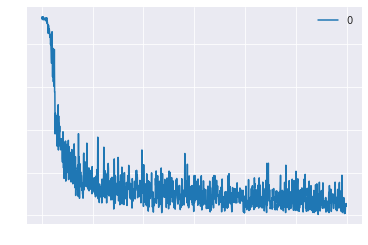

In [14]:
pd.DataFrame(losses).plot()
plt.tick_params(colors='white')

In [15]:
num_TP = 0.
num_total = 0
cm = np.zeros((10, 10))
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = clf_nn(inputs)
        _, pred = torch.max(outputs.data, 1)
        cm += np.array(confusion_matrix(pred, labels, labels=np.arange(10)))
        num_total += labels.size(0)
        num_TP += (pred == labels).sum().item()
print(f'Accuracy: {num_TP / num_total * 100}%')

Accuracy: 95.61%


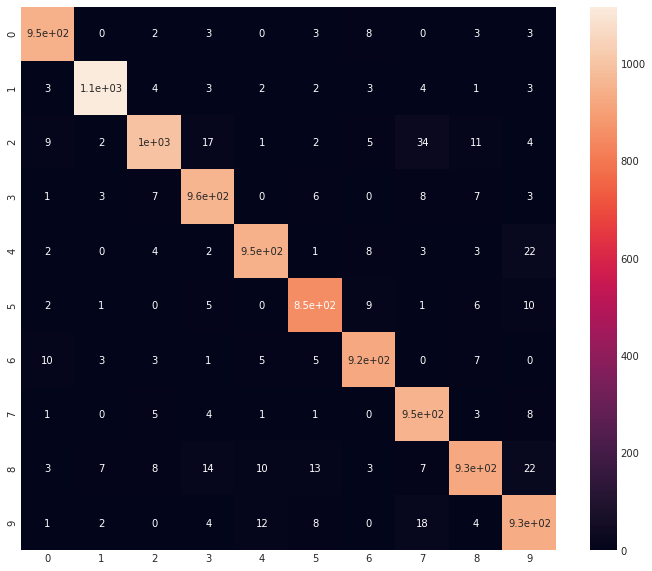

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, ax=ax)
sns.set_style("darkgrid")